# Covid19

This notebook is an example on how to use the VerticaPy Library. We will use the Covid19 dataset to predict the number of deaths and cases one day in advance. You can download the Jupyter Notebook of the study by clicking <a href="covid19.ipynb">here</a>. To achieve our goals, we have access to the following data. 
<ul class="ul_elem">
    <li><b>date: </b>Date of the record</li>
    <li><b>cases: </b>Number of people infected by the virus</li>
    <li><b>deaths: </b>Number of deaths</li>
    <li><b>state: </b>State</li>
    <li><b>county: </b>County</li>
</ul>
The dataset is available by clicking <a href="../../data/covid19_deaths.csv">here</a>.

We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.

## Initialization

Let's create a Virtual DataFrame of the dataset.

In [1]:
from verticapy import *
covid19 = vDataFrame("covid19_deaths")
print(covid19)

,county,fips,cases,date,state,deaths
0,Snohomish,53061,1,2020-01-21,Washington,0
1,Snohomish,53061,1,2020-01-22,Washington,0
2,Snohomish,53061,1,2020-01-23,Washington,0
3,Cook,17031,1,2020-01-24,Illinois,0
4,Snohomish,53061,1,2020-01-24,Washington,0
,...,...,...,...,...,...


<object>  Name: covid19_deaths, Number of rows: 128256, Number of columns: 6


## Data Exploration and Preparation

Let's explore the data by displaying descriptive statistics of all the columns.

In [2]:
covid19.describe(method = "categorical")

,dtype,unique,count,top,top_percent
"""county""",varchar(66),1710,128256,Washington,1.163
"""fips""",int,2882,128256,53061,0.086
"""cases""",int,3830,128256,1,13.376
"""date""",date,110,128256,2020-05-09,2.247
"""state""",varchar(48),51,128256,Texas,6.71
"""deaths""",int,806,128256,0,61.125


<object>

Data are available from January 2020 to the beginning of May.

In [3]:
covid19["date"].describe()

,value
name,"""date"""
dtype,date
count,128256
min,2020-01-21
max,2020-05-09


<object>

We will focus the study on predicting the number of deaths by state using the previous days. We can drop the columns 'county' and 'fips'.

In [4]:
covid19.drop(["fips", "county"])

,cases,date,state,deaths
0,1,2020-01-21,Washington,0
1,1,2020-01-22,Washington,0
2,1,2020-01-23,Washington,0
3,1,2020-01-24,Illinois,0
4,1,2020-01-24,Washington,0
,...,...,...,...


<object>  Name: covid19_deaths, Number of rows: 128256, Number of columns: 4

Let's sum the number of deaths and cases by state and date.

In [5]:
covid19 = covid19.groupby(["state",
                           "date"],
                          ["SUM(deaths) AS deaths",
                           "SUM(cases) AS cases"])
print(covid19)

,state,date,deaths,cases
0,North Dakota,2020-04-23,15,709
1,North Dakota,2020-04-21,13,644
2,North Dakota,2020-04-27,19,942
3,North Dakota,2020-04-25,16,803
4,North Dakota,2020-04-15,9,365
,...,...,...,...


<object>  Name: groupby, Number of rows: 3513, Number of columns: 4


Let's look at the auto-correlation graphic of the number of 'deaths'.

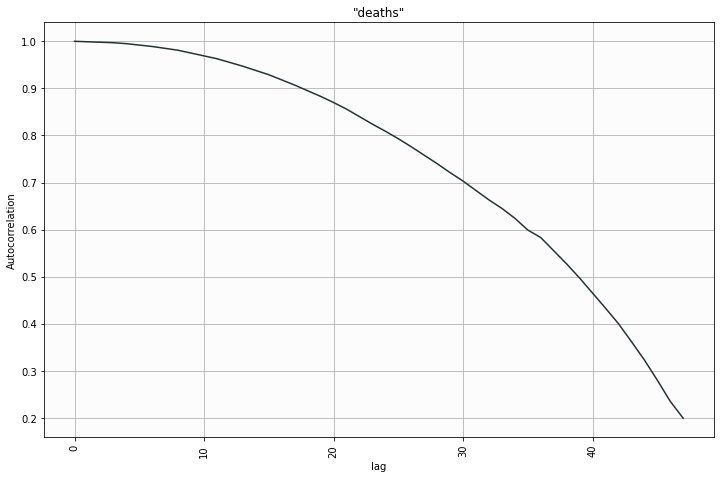

In [6]:
%matplotlib inline
x = covid19.autocorr(column = "deaths", 
                     ts = "date",
                     by = ["state"],
                     p = 48)

The process seems to not be stationary. Let's use a Dickey Fuller test to confirm our hypothesis.

In [7]:
covid19.testdf(ts = "date", column = "deaths", by = ["state"], p = 12)

We test the following hypothesis:
(H0) The time series "deaths" = f("date") is non-stationary
(H1) The time series "deaths" = f("date") is stationary
👎 - The Process might be non-stationary (time dependent structure)
gamma + 1 = 1.143104156849998
p_value = 1.93392296854719e-14


(False, 1.143104156849998, 1.93392296854719e-14)

We can look at the cumulative number of deaths to see the exponentiality of the process.

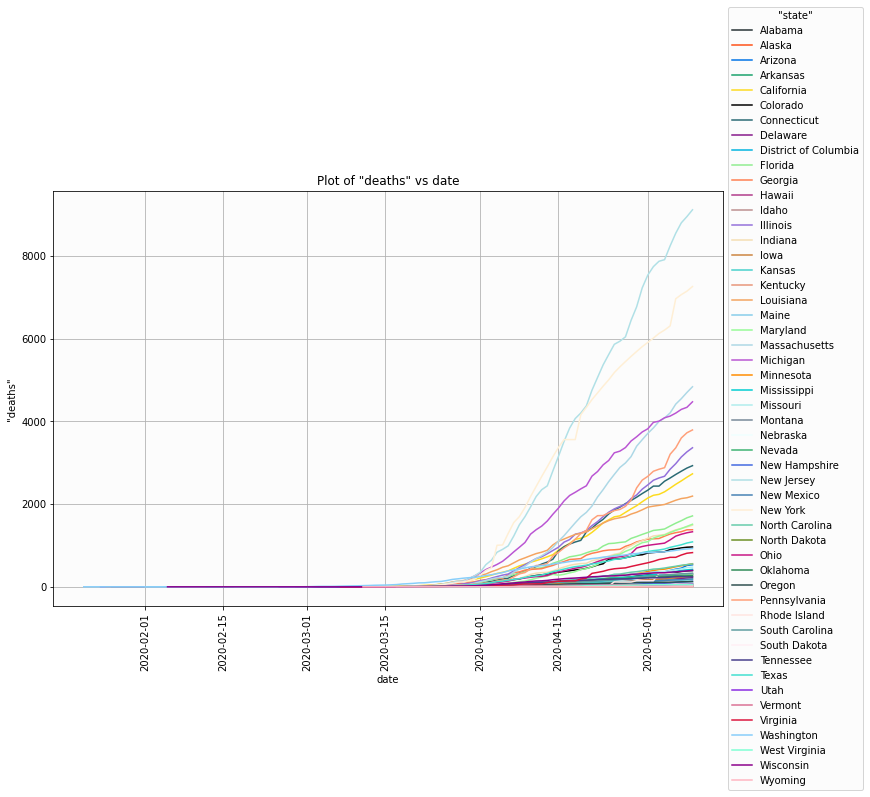

In [8]:
x = covid19["deaths"].plot(ts = "date", by = "state")

Let's see the phenomenon in the entire country.

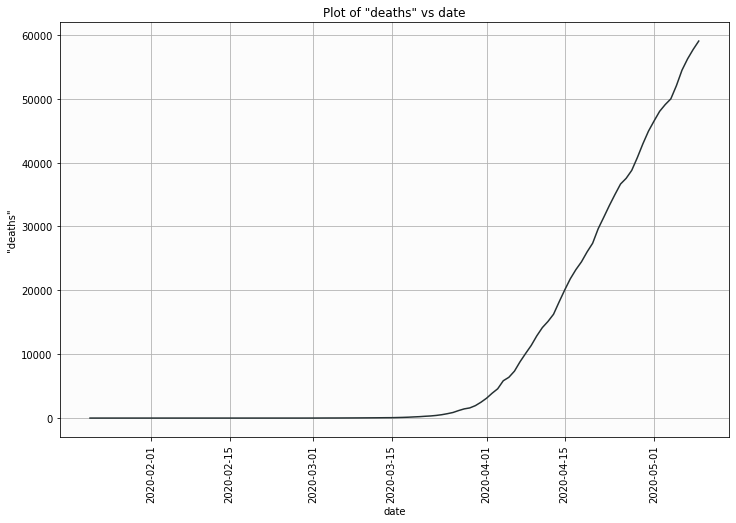

In [9]:
covid = covid19.groupby(["date"], ["SUM(deaths) AS deaths"])
x = covid["deaths"].plot(ts = "date")

We can also see a clear correlation between the number of people infected and the number of deaths.

In [10]:
covid19.corr(["deaths", "cases"])

0.954246238080928

Let's compute lags of the 2 main variables.

In [11]:
for i in range(1, 5):
    covid19.analytic(func = "lag", 
                     column = "deaths", 
                     by = ["state"], 
                     order_by = ["date"],
                     name = "lag_deaths_{}".format(i),
                     offset = i)
    covid19.analytic(func = "lag", 
                     column = "cases", 
                     by = ["state"], 
                     order_by = ["date"],
                     name = "lag_cases_{}".format(i),
                     offset = i)

We need to encode the states, if we want to use them as predictors.

In [12]:
covid19["state"].get_dummies()

,state,date,deaths,cases,lag_deaths_1,lag_cases_1,lag_deaths_2,lag_cases_2,lag_deaths_3,lag_cases_3,lag_deaths_4,lag_cases_4,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District_of_Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New_Hampshire,state_New_Jersey,state_New_Mexico,state_New_York,state_North_Carolina,state_North_Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode_Island,state_South_Carolina,state_South_Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West_Virginia,state_Wisconsin
0,Arizona,2020-01-26,0,1,None,None,None,None,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arizona,2020-01-27,0,1,0,1,None,None,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arizona,2020-01-28,0,1,0,1,0,1,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arizona,2020-01-29,0,1,0,1,0,1,0,1,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Arizona,2020-01-30,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 3513, Number of columns: 62

We can also add the elapsed number of days as predictor.

In [13]:
covid19.eval(expr = "TIMESTAMPDIFF(DAY, MIN(date) OVER (PARTITION BY state), date)",
             name = "elapsed_days")

,state,date,deaths,cases,lag_deaths_1,lag_cases_1,lag_deaths_2,lag_cases_2,lag_deaths_3,lag_cases_3,lag_deaths_4,lag_cases_4,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District_of_Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New_Hampshire,state_New_Jersey,state_New_Mexico,state_New_York,state_North_Carolina,state_North_Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode_Island,state_South_Carolina,state_South_Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West_Virginia,state_Wisconsin,elapsed_days
0,Arizona,2020-01-26,0,1,None,None,None,None,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arizona,2020-01-27,0,1,0,1,None,None,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Arizona,2020-01-28,0,1,0,1,0,1,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,Arizona,2020-01-29,0,1,0,1,0,1,0,1,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,Arizona,2020-01-30,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 3513, Number of columns: 63

We can look at the SQL code generation of the vDataFrame to see what is happening behind the scene.

In [14]:
print(covid19.current_relation())

(
   SELECT
     "state",
     "date",
     "deaths",
     "cases",
     LAG("deaths", 1) OVER (PARTITION BY "state"  ORDER BY date) AS "lag_deaths_1",
     LAG("cases", 1) OVER (PARTITION BY "state"  ORDER BY date) AS "lag_cases_1",
     LAG("deaths", 2) OVER (PARTITION BY "state"  ORDER BY date) AS "lag_deaths_2",
     LAG("cases", 2) OVER (PARTITION BY "state"  ORDER BY date) AS "lag_cases_2",
     LAG("deaths", 3) OVER (PARTITION BY "state"  ORDER BY date) AS "lag_deaths_3",
     LAG("cases", 3) OVER (PARTITION BY "state"  ORDER BY date) AS "lag_cases_3",
     LAG("deaths", 4) OVER (PARTITION BY "state"  ORDER BY date) AS "lag_deaths_4",
     LAG("cases", 4) OVER (PARTITION BY "state"  ORDER BY date) AS "lag_cases_4",
     DECODE("state_Alabama", 'Alabama', 1, 0) AS "state_Alabama",
     DECODE("state_Alaska", 'Alaska', 1, 0) AS "state_Alaska",
     DECODE("state_Arizona", 'Arizona', 1, 0) AS "state_Arizona",
     DECODE("state_Arkansas", 'Arkansas', 1, 0) AS "state_Arkansas",
    

Waw! The object is memorizing all the needed actions to generate the correct SQL statement.

Let's save the view in the Vertica DB to create our linear regression model.

In [15]:
from verticapy.utilities import drop_view
drop_view("covid19_clean")
covid19.to_db("covid19_clean")

The view covid19_clean was successfully dropped.


,state,date,deaths,cases,lag_deaths_1,lag_cases_1,lag_deaths_2,lag_cases_2,lag_deaths_3,lag_cases_3,lag_deaths_4,lag_cases_4,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District_of_Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New_Hampshire,state_New_Jersey,state_New_Mexico,state_New_York,state_North_Carolina,state_North_Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode_Island,state_South_Carolina,state_South_Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West_Virginia,state_Wisconsin,elapsed_days
0,Alabama,2020-03-13,0,6,None,None,None,None,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alabama,2020-03-14,0,12,0,6,None,None,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Alabama,2020-03-15,0,23,0,12,0,6,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,Alabama,2020-03-16,0,29,0,23,0,12,0,6,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,Alabama,2020-03-17,0,39,0,29,0,23,0,12,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 3513, Number of columns: 63

## Machine Learning

Let's create a Linear Regression model to predict the number of Covid19 deaths in advance by state.

In [16]:
from verticapy.learn.linear_model import LinearRegression
from verticapy.learn.model_selection import cross_validate
from verticapy.utilities import drop_model

predictors = covid19.get_columns(exclude_columns = ["state", 
                                                    "date", 
                                                    "deaths", 
                                                    "cases"])
response = "deaths"
relation = "covid19_clean"
drop_model("covid19_lr")
model = LinearRegression("covid19_lr")
cross_validate(model, relation, predictors, response)

The model covid19_lr was successfully dropped.


,explained_variance,max_error,median_absolute_error,mean_absolute_error,mean_squared_error,r2
1-fold,0.999472444286823,211.006058584241,2.50286297233424,8.64047112306561,416.468808805438,0.999500054480133
2-fold,0.998706231860807,561.964754359189,2.10420133921563,9.67219422578796,1195.50883760323,0.998766494703786
3-fold,0.999251241081189,273.034290214122,2.68356071670842,9.18618438422774,544.520263831059,0.999288374323203
avg,0.9991433057429396,348.668367719184,2.4302083427527634,9.166283244360438,718.8326367465756,0.999184974502374
std,0.0003943448977451052,187.30559734040096,0.2964343830798386,0.5161493792486544,417.74925988072647,0.00037755281561549324


<object>

The model is excellent as expected. Let's create the final model using the entire dataset.

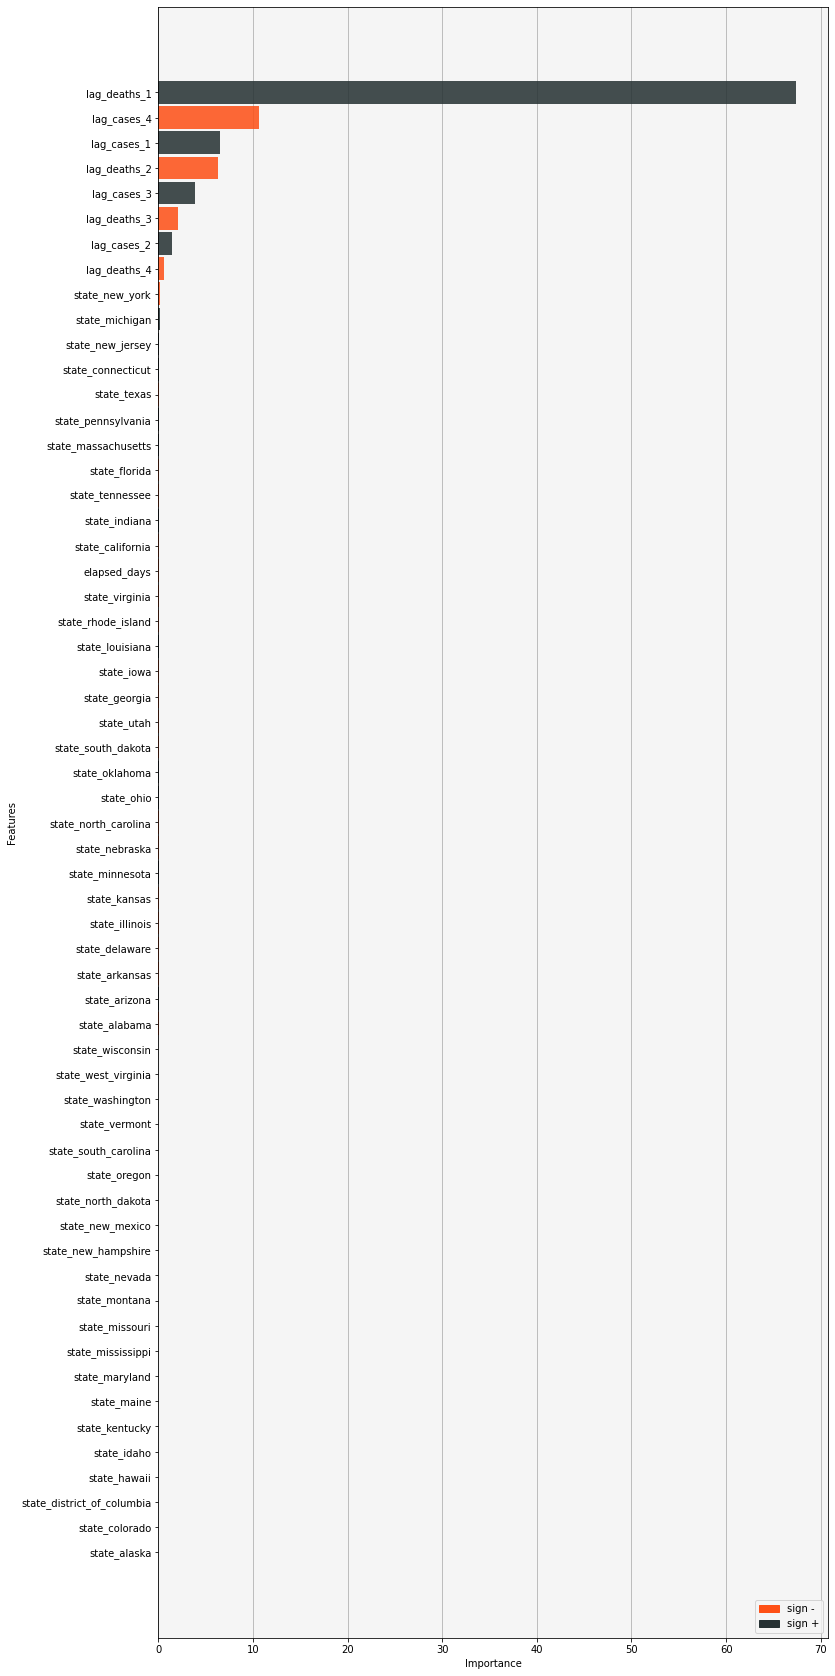

In [17]:
model.fit(relation, predictors, response)
x = model.features_importance()

Many variables are useless for the predictions. Only the lags are important. Let's build a model with only the valuable variables.

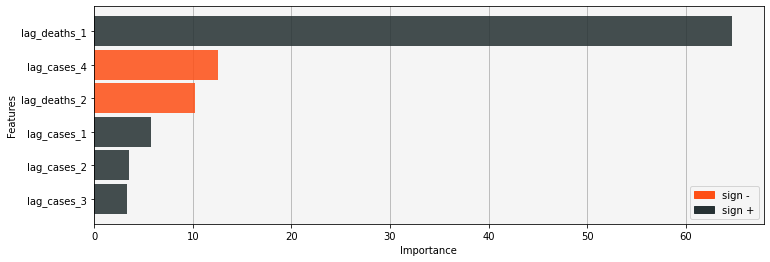

In [18]:
model.drop()
model.fit(relation, 
          ["lag_deaths_1",
           "lag_deaths_2",
           "lag_cases_1",
           "lag_cases_2",
           "lag_cases_3",
           "lag_cases_4"], 
          response)
x = model.features_importance()

Let's add the prediction in the vDataFrame.

In [19]:
model.predict(covid19, "prediction")

,state,date,deaths,cases,lag_deaths_1,lag_cases_1,lag_deaths_2,lag_cases_2,lag_deaths_3,lag_cases_3,lag_deaths_4,lag_cases_4,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District_of_Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New_Hampshire,state_New_Jersey,state_New_Mexico,state_New_York,state_North_Carolina,state_North_Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode_Island,state_South_Carolina,state_South_Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West_Virginia,state_Wisconsin,elapsed_days,prediction
0,Arizona,2020-01-26,0,1,None,None,None,None,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None
1,Arizona,2020-01-27,0,1,0,1,None,None,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,None
2,Arizona,2020-01-28,0,1,0,1,0,1,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,None
3,Arizona,2020-01-29,0,1,0,1,0,1,0,1,None,None,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,None
4,Arizona,2020-01-30,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,-0.37044163213379
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 3513, Number of columns: 64

Let's impute the missing values due to the lags computations by 0 and round the negative predictions to 0 as they are impossible.

In [20]:
covid19["prediction"].fillna(val = 0)
covid19["prediction"].apply("CASE WHEN {} < 0 THEN 0 ELSE {} END")

204 element(s) was/were filled


,state,date,deaths,cases,lag_deaths_1,lag_cases_1,lag_deaths_2,lag_cases_2,lag_deaths_3,lag_cases_3,lag_deaths_4,lag_cases_4,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District_of_Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New_Hampshire,state_New_Jersey,state_New_Mexico,state_New_York,state_North_Carolina,state_North_Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode_Island,state_South_Carolina,state_South_Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West_Virginia,state_Wisconsin,elapsed_days,prediction
0,Alabama,2020-03-13,0,6,None,None,None,None,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,Alabama,2020-03-14,0,12,0,6,None,None,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0
2,Alabama,2020-03-15,0,23,0,12,0,6,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.0
3,Alabama,2020-03-16,0,29,0,23,0,12,0,6,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.0
4,Alabama,2020-03-17,0,39,0,29,0,23,0,12,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0.0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 3513, Number of columns: 64

Let's compute our new R2.

In [21]:
covid19.score(y_score = "prediction",
              y_true = "deaths",
              method = "r2")

0.999262153810739

Fantastic ! Let's group to compute the total number of deaths in USA to see how good is our prediction.

In [22]:
covid = covid19.groupby(["date"], 
                        ["SUM(deaths) AS deaths", 
                         "SUM(prediction) AS prediction"])

Let's draw the TS Plot.

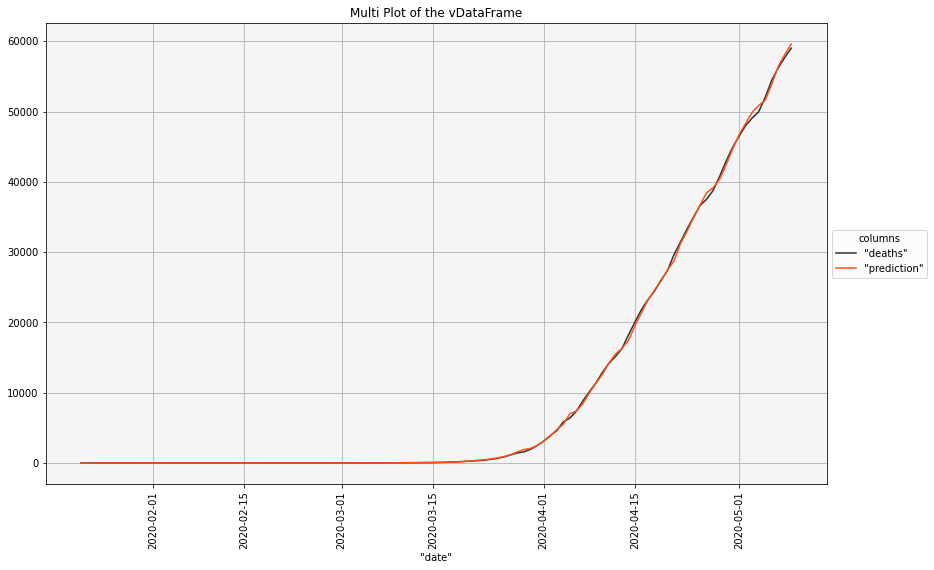

,date,deaths,prediction
0,2020-01-21,0,0.0
1,2020-01-22,0,0.0
2,2020-01-23,0,0.0
3,2020-01-24,0,0.0
4,2020-01-25,0,0.0
,...,...,...


<object>  Name: groupby, Number of rows: 110, Number of columns: 3

In [23]:
covid.plot(ts = "date", columns = ["deaths", "prediction"])

Fantastic: Our prediction seems to follow the trend ! 

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.